In [1]:
!pip install -q transformers datasets evaluate accelerate gluonts ujson

In [2]:
!pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import lru_cache, partial
import pandas as pd
import numpy as np
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from pandas.core.arrays.period import period_array
from transformers import InformerConfig, InformerForPrediction
from transformers import PretrainedConfig
from typing import Optional

from gluonts.transform.sampler import InstanceSampler


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from accelerate import Accelerator
from torch.optim import AdamW

In [4]:
tc_dataset = load_dataset("shaddie/thrust_curves_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# Specify train/test split fraction
train_fraction = 0.9  # 80% for training, 20% for testing

# Split the original training set into new train/test sets
split_dataset = tc_dataset["train"].train_test_split(train_size=train_fraction, seed=42)

In [6]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 239
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 27
    })
})

In [7]:
def find_pad_max(dataset):
    l=len(dataset)
    m = 0
    for r in range(l):
        # real = tc_dataset[split][r]['feat_dynamic_real']
        target = dataset[r]['target']
        if m < len(target):
            m = len(target)

    return m


def pad_data(data, m, split):
    l=len(data)
    tc = []
    for r in range(l):
        real = data[r]['feat_dynamic_real']
        target = data[r]['target']
        rlen = len(real)
        pad = [0 for _ in range(m-rlen)]
        # target = tc_dataset['train'][r]['target']
        real = real + pad
        target = target + pad
        tc.append({
            'start': data[r]['start'],
            'target': target,
            'feat_static_cat': data[r]['feat_static_cat'],
            'feat_dynamic_real': real,
            'item_id': data[r]['item_id']
                }
            )

    return tc

In [8]:
from datasets import Dataset
m1 = find_pad_max(split_dataset["train"])
m2 = find_pad_max(split_dataset["test"])
m = max(m1,m2)
print(m)

61


In [9]:
train_data = pad_data(split_dataset["train"], m=m, split="train")
test_data = pad_data(split_dataset["test"], m=m, split="test")

In [10]:
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

In [11]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 239
})

In [12]:
test_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 27
})

In [13]:
freq = "1W"
prediction_length = 8

# assert len(train_example["target"]) + prediction_length == len(
#     dataset["validation"][0]["target"]
# )

In [14]:
train_example = train_dataset[0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

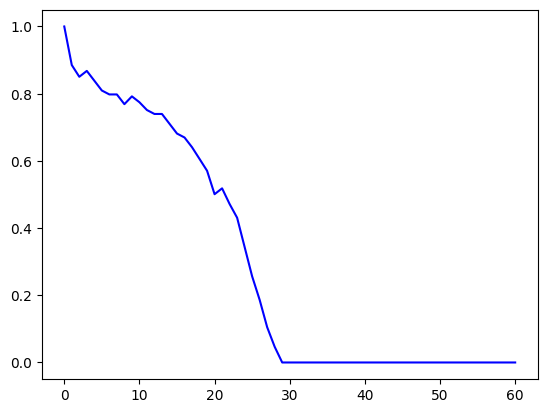

In [15]:
num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(
          # train_example["feat_dynamic_real"][-num_of_samples:],
          train_example["target"][-num_of_samples:],
          color="blue")

plt.show()

In [16]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [17]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [18]:
num_of_variates = len(test_dataset) # group according to the smaller test dataset size

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates
    # max_target_dim=num_of_variates,
    # num_test_dates=len(test_dataset),
    # num_test_dates=None, # len(test_dataset),
    # num_of_variates=num  # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [19]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (27, 99)


In [20]:
multi_variate_test_example = multi_variate_test_dataset[0]
print(
    f"multi_variate_test_example['target'].shape = {multi_variate_test_example['target'].shape}"
)

multi_variate_test_example['target'].shape = (27, 95)


In [21]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_month at 0x7e4e7785a520>, <function week_of_year at 0x7e4e7785a8e0>]


Look back certain time range for each time step, as additional features "lags_sequence"

In [22]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157]


In [23]:
timestamp = pd.Period("2025-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_month': array([-0.36666667]), 'week_of_year': array([-0.5])}


In [24]:
model = None

In [25]:
from transformers import InformerForPrediction

In [26]:
try:
    model = InformerForPrediction.from_pretrained("shaddie/rocketpill_thrustcurve_informer_model")
    print(f"successfully loaded model from hugging face with Config {model.config}")
except:
    print(f"An exception occurred when loading model from HF; initializing new model...")
    config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
    )

    model = InformerForPrediction(config)
    print(f"New model initialized with config {model.config}")

An exception occurred when loading model from HF; initializing new model...
New model initialized with config InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 16,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 6,
  "feature_size": 111,
  "init_std": 0.02,
  "input_size": 27,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    168
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 3,
  "prediction

In [27]:
model.config.distribution_output

'student_t'

In [28]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [29]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [30]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [31]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [32]:
config = model.config

In [33]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)


In [34]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 184, 3]) torch.FloatTensor
past_values torch.Size([256, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([256, 184, 27]) torch.FloatTensor
future_time_features torch.Size([256, 8, 3]) torch.FloatTensor
future_values torch.Size([256, 8, 27]) torch.FloatTensor
future_observed_mask torch.Size([256, 8, 27]) torch.FloatTensor


In [35]:
batch = next(iter(test_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([1, 184, 3]) torch.FloatTensor
past_values torch.Size([1, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([1, 184, 27]) torch.FloatTensor
future_time_features torch.Size([1, 8, 3]) torch.FloatTensor


In [ ]:
from tqdm import tqdm
epochs = 300
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
    for idx, batch in enumerate(progress_bar):
        # print(f'idx: {idx}')
        # for k, v in batch.items():
        #     print(k, v.shape, v.type())
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 200 == 0:
            print(f'Epoch {epoch} & idx {idx} with loss: {loss.item()}')

Epoch 1/300 : 1it [00:04,  4.11s/it, loss=-70.6]

Epoch 0 & idx 0 with loss: -70.58369445800781


Epoch 1/300 : 100it [01:02,  1.59it/s, loss=-103]
Epoch 2/300 : 1it [00:00,  4.81it/s, loss=-117]

Epoch 1 & idx 0 with loss: -116.98674011230469


Epoch 2/300 : 100it [00:22,  4.43it/s, loss=-129]
Epoch 3/300 : 2it [00:00,  8.06it/s, loss=-129]

Epoch 2 & idx 0 with loss: -127.97795104980469


Epoch 3/300 : 100it [00:13,  7.40it/s, loss=-139]
Epoch 4/300 : 2it [00:00,  8.28it/s, loss=-149]

Epoch 3 & idx 0 with loss: -145.09506225585938


Epoch 4/300 : 100it [00:13,  7.34it/s, loss=-146]
Epoch 5/300 : 2it [00:00,  6.86it/s, loss=-149]

Epoch 4 & idx 0 with loss: -147.9849853515625


Epoch 5/300 : 100it [00:13,  7.53it/s, loss=-153]
Epoch 6/300 : 2it [00:00,  7.14it/s, loss=-155]

Epoch 5 & idx 0 with loss: -163.15478515625


Epoch 6/300 : 100it [00:13,  7.56it/s, loss=-155]
Epoch 7/300 : 2it [00:00,  8.39it/s, loss=-168]

Epoch 6 & idx 0 with loss: -168.4783172607422


Epoch 7/300 : 100it [00:13,  7.40it/s, loss=-158]
Epoch 8/300 : 2it [00:00,  8.00it/s, loss=-167]

Epoch 7 & idx 0 with loss: -173.69935607910156


Epoch 8/300 : 100it [00:13,  7.30it/s, loss=-160]
Epoch 9/300 : 1it [00:00,  5.07it/s, loss=-173]

Epoch 8 & idx 0 with loss: -176.97283935546875


Epoch 9/300 : 100it [00:13,  7.19it/s, loss=-160]
Epoch 10/300 : 2it [00:00,  5.28it/s, loss=-165]

Epoch 9 & idx 0 with loss: -173.28652954101562


Epoch 10/300 : 100it [00:21,  4.69it/s, loss=-164]
Epoch 11/300 : 2it [00:00,  8.04it/s, loss=-164]

Epoch 10 & idx 0 with loss: -168.84068298339844


Epoch 11/300 : 100it [00:13,  7.39it/s, loss=-164]
Epoch 12/300 : 2it [00:00,  7.85it/s, loss=-157]

Epoch 11 & idx 0 with loss: -156.88262939453125


Epoch 12/300 : 100it [00:13,  7.51it/s, loss=-166]
Epoch 13/300 : 2it [00:00,  8.23it/s, loss=-168]

Epoch 12 & idx 0 with loss: -179.80960083007812


Epoch 13/300 : 100it [00:13,  7.24it/s, loss=-165]
Epoch 14/300 : 2it [00:00,  6.15it/s, loss=-164]

Epoch 13 & idx 0 with loss: -164.31396484375


Epoch 14/300 : 100it [00:13,  7.16it/s, loss=-169]
Epoch 15/300 : 2it [00:00,  7.93it/s, loss=-173]

Epoch 14 & idx 0 with loss: -172.98988342285156


Epoch 15/300 : 100it [00:13,  7.41it/s, loss=-169]
Epoch 16/300 : 2it [00:00,  8.02it/s, loss=-164]

Epoch 15 & idx 0 with loss: -170.96044921875


Epoch 16/300 : 100it [00:13,  7.44it/s, loss=-171]
Epoch 17/300 : 2it [00:00,  7.35it/s, loss=-174]

Epoch 16 & idx 0 with loss: -179.68582153320312


Epoch 17/300 : 100it [00:13,  7.37it/s, loss=-171]
Epoch 18/300 : 2it [00:00,  8.42it/s, loss=-162]

Epoch 17 & idx 0 with loss: -163.76806640625


Epoch 18/300 : 100it [00:13,  7.56it/s, loss=-171]
Epoch 19/300 : 2it [00:00,  7.41it/s, loss=-168]

Epoch 18 & idx 0 with loss: -166.4527587890625


Epoch 19/300 : 100it [00:13,  7.58it/s, loss=-172]
Epoch 20/300 : 2it [00:00,  8.22it/s, loss=-178]

Epoch 19 & idx 0 with loss: -168.98519897460938


Epoch 20/300 : 100it [00:13,  7.53it/s, loss=-172]
Epoch 21/300 : 2it [00:00,  8.06it/s, loss=-171]

Epoch 20 & idx 0 with loss: -162.26608276367188


Epoch 21/300 : 100it [00:13,  7.45it/s, loss=-176]
Epoch 22/300 : 2it [00:00,  7.40it/s, loss=-173]

Epoch 21 & idx 0 with loss: -179.29412841796875


Epoch 22/300 : 100it [00:13,  7.39it/s, loss=-175]
Epoch 23/300 : 2it [00:00,  7.93it/s, loss=-172]

Epoch 22 & idx 0 with loss: -168.396728515625


Epoch 23/300 : 100it [00:13,  7.45it/s, loss=-174]
Epoch 24/300 : 2it [00:00,  7.37it/s, loss=-179]

Epoch 23 & idx 0 with loss: -173.22964477539062


Epoch 24/300 : 100it [00:13,  7.37it/s, loss=-176]
Epoch 25/300 : 2it [00:00,  7.34it/s, loss=-186]

Epoch 24 & idx 0 with loss: -181.47879028320312


Epoch 25/300 : 100it [00:13,  7.55it/s, loss=-178]
Epoch 26/300 : 2it [00:00,  6.05it/s, loss=-180]

Epoch 25 & idx 0 with loss: -180.67135620117188


Epoch 26/300 : 100it [00:13,  7.47it/s, loss=-178]
Epoch 27/300 : 2it [00:00,  5.59it/s, loss=-176]

Epoch 26 & idx 0 with loss: -179.77114868164062


Epoch 27/300 : 100it [00:13,  7.33it/s, loss=-178]
Epoch 28/300 : 2it [00:00,  8.19it/s, loss=-176]

Epoch 27 & idx 0 with loss: -161.8790740966797


Epoch 28/300 : 100it [00:13,  7.50it/s, loss=-180]
Epoch 29/300 : 2it [00:00,  8.34it/s, loss=-171]

Epoch 28 & idx 0 with loss: -176.09640502929688


Epoch 29/300 : 100it [00:13,  7.41it/s, loss=-180]
Epoch 30/300 : 2it [00:00,  8.06it/s, loss=-172]

Epoch 29 & idx 0 with loss: -174.40377807617188


Epoch 30/300 : 100it [00:13,  7.45it/s, loss=-180]
Epoch 31/300 : 2it [00:00,  6.98it/s, loss=-185]

Epoch 30 & idx 0 with loss: -180.28524780273438


Epoch 31/300 : 100it [00:13,  7.29it/s, loss=-180]
Epoch 32/300 : 2it [00:00,  8.00it/s, loss=-179]

Epoch 31 & idx 0 with loss: -175.02395629882812


Epoch 32/300 : 100it [00:13,  7.43it/s, loss=-180]
Epoch 33/300 : 2it [00:00,  8.39it/s, loss=-180]

Epoch 32 & idx 0 with loss: -192.87557983398438


Epoch 33/300 : 100it [00:13,  7.38it/s, loss=-183]
Epoch 34/300 : 2it [00:00,  7.86it/s, loss=-186]

Epoch 33 & idx 0 with loss: -181.30197143554688


Epoch 34/300 : 100it [00:13,  7.30it/s, loss=-182]
Epoch 35/300 : 2it [00:00,  7.95it/s, loss=-176]

Epoch 34 & idx 0 with loss: -190.28884887695312


Epoch 35/300 : 100it [00:13,  7.36it/s, loss=-183]
Epoch 36/300 : 2it [00:00,  7.78it/s, loss=-186]

Epoch 35 & idx 0 with loss: -182.43850708007812


Epoch 36/300 : 100it [00:13,  7.36it/s, loss=-182]
Epoch 37/300 : 2it [00:00,  8.36it/s, loss=-184]

Epoch 36 & idx 0 with loss: -180.2036590576172


Epoch 37/300 : 100it [00:13,  7.25it/s, loss=-184]
Epoch 38/300 : 2it [00:00,  6.08it/s, loss=-186]

Epoch 37 & idx 0 with loss: -173.17974853515625


Epoch 38/300 : 100it [00:13,  7.20it/s, loss=-186]
Epoch 39/300 : 2it [00:00,  6.70it/s, loss=-197]

Epoch 38 & idx 0 with loss: -191.17633056640625


Epoch 39/300 : 100it [00:13,  7.38it/s, loss=-186]
Epoch 40/300 : 2it [00:00,  7.99it/s, loss=-188]

Epoch 39 & idx 0 with loss: -186.50497436523438


Epoch 40/300 : 100it [00:13,  7.56it/s, loss=-184]
Epoch 41/300 : 2it [00:00,  7.52it/s, loss=-185]

Epoch 40 & idx 0 with loss: -185.969482421875


Epoch 41/300 : 100it [00:13,  7.43it/s, loss=-184]
Epoch 42/300 : 2it [00:00,  7.82it/s, loss=-180]

Epoch 41 & idx 0 with loss: -171.50527954101562


Epoch 42/300 : 100it [00:13,  7.42it/s, loss=-187]
Epoch 43/300 : 2it [00:00,  8.27it/s, loss=-166]

Epoch 42 & idx 0 with loss: -173.14315795898438


Epoch 43/300 : 100it [00:13,  7.60it/s, loss=-185]
Epoch 44/300 : 2it [00:00,  8.02it/s, loss=-189]

Epoch 43 & idx 0 with loss: -194.35415649414062


Epoch 44/300 : 100it [00:13,  7.45it/s, loss=-187]
Epoch 45/300 : 2it [00:00,  7.73it/s, loss=-175]

Epoch 44 & idx 0 with loss: -181.99632263183594


Epoch 45/300 : 100it [00:13,  7.43it/s, loss=-187]
Epoch 46/300 : 2it [00:00,  8.10it/s, loss=-188]

Epoch 45 & idx 0 with loss: -186.5103759765625


Epoch 46/300 : 100it [00:13,  7.22it/s, loss=-187]
Epoch 47/300 : 2it [00:00,  8.00it/s, loss=-187]

Epoch 46 & idx 0 with loss: -187.45516967773438


Epoch 47/300 : 100it [00:13,  7.41it/s, loss=-188]
Epoch 48/300 : 2it [00:00,  7.71it/s, loss=-191]

Epoch 47 & idx 0 with loss: -192.3115234375


Epoch 48/300 : 100it [00:13,  7.41it/s, loss=-187]
Epoch 49/300 : 2it [00:00,  7.30it/s, loss=-182]

Epoch 48 & idx 0 with loss: -179.60169982910156


Epoch 49/300 : 100it [00:13,  7.16it/s, loss=-190]
Epoch 50/300 : 2it [00:00,  6.01it/s, loss=-191]

Epoch 49 & idx 0 with loss: -187.43023681640625


Epoch 50/300 : 100it [00:13,  7.29it/s, loss=-187]
Epoch 51/300 : 2it [00:00,  8.33it/s, loss=-164]

Epoch 50 & idx 0 with loss: -162.52432250976562


Epoch 51/300 : 100it [00:13,  7.51it/s, loss=-188]
Epoch 52/300 : 2it [00:00,  7.20it/s, loss=-186]

Epoch 51 & idx 0 with loss: -185.70021057128906


Epoch 52/300 : 100it [00:13,  7.55it/s, loss=-189]
Epoch 53/300 : 2it [00:00,  8.37it/s, loss=-181]

Epoch 52 & idx 0 with loss: -180.02999877929688


Epoch 53/300 : 100it [00:13,  7.49it/s, loss=-188]
Epoch 54/300 : 2it [00:00,  7.73it/s, loss=-188]

Epoch 53 & idx 0 with loss: -185.05783081054688


Epoch 54/300 : 100it [00:13,  7.38it/s, loss=-190]
Epoch 55/300 : 2it [00:00,  7.28it/s, loss=-176]

Epoch 54 & idx 0 with loss: -193.59597778320312


Epoch 55/300 : 100it [00:13,  7.50it/s, loss=-189]
Epoch 56/300 : 2it [00:00,  8.07it/s, loss=-180]

Epoch 55 & idx 0 with loss: -165.11196899414062


Epoch 56/300 : 100it [00:13,  7.56it/s, loss=-189]
Epoch 57/300 : 2it [00:00,  8.14it/s, loss=-194]

Epoch 56 & idx 0 with loss: -193.03187561035156


Epoch 57/300 : 100it [00:13,  7.52it/s, loss=-190]
Epoch 58/300 : 2it [00:00,  6.56it/s, loss=-200]

Epoch 57 & idx 0 with loss: -200.10845947265625


Epoch 58/300 : 100it [00:13,  7.46it/s, loss=-189]
Epoch 59/300 : 2it [00:00,  8.12it/s, loss=-174]

Epoch 58 & idx 0 with loss: -173.01019287109375


Epoch 59/300 : 100it [00:14,  7.13it/s, loss=-193]
Epoch 60/300 : 2it [00:00,  8.02it/s, loss=-181]

Epoch 59 & idx 0 with loss: -192.4285888671875


Epoch 60/300 : 100it [00:13,  7.41it/s, loss=-191]
Epoch 61/300 : 2it [00:00,  8.26it/s, loss=-192]

Epoch 60 & idx 0 with loss: -191.58212280273438


Epoch 61/300 : 100it [00:14,  7.14it/s, loss=-191]
Epoch 62/300 : 2it [00:00,  5.60it/s, loss=-188]

Epoch 61 & idx 0 with loss: -192.36489868164062


Epoch 62/300 : 100it [00:14,  7.12it/s, loss=-191]
Epoch 63/300 : 2it [00:00,  7.30it/s, loss=-196]

Epoch 62 & idx 0 with loss: -196.0679168701172


Epoch 63/300 : 100it [00:13,  7.27it/s, loss=-191]
Epoch 64/300 : 2it [00:00,  7.74it/s, loss=-192]

Epoch 63 & idx 0 with loss: -193.14398193359375


Epoch 64/300 : 40it [00:05,  7.73it/s, loss=-193]

In [ ]:
# import os
# work_dir = os.getcwd()
# work_dir = os.getcwd()
# data_dir = work_dir.replace("GitHub/RocketPill/ipynb-notebooks", "Data/")

In [ ]:
# view training
from datetime import datetime

loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
# plt.savefig(data_dir+"hf_informer4roqeto_loss_curve_"+str(datetime.now()).replace(":",".")+".png")
plt.show()

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# model.push_to_hub("shaddie/rocketpill_ts_informer_model",
#                   use_auth_token=True,
#                   commit_message="training-time-series-thrust-curve",
#                   private=False)

In [ ]:
# model

In [ ]:
model.eval()

forecasts_ = []

test_progress_bar = tqdm(test_dataloader, desc=f"Epoch ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
for idx, batch in enumerate(test_progress_bar):
  for k, v in batch.items():
    print(k, v.shape, v.type())
  # print(f'past_observed_mask {batch["past_observed_mask"].to(device).repeat(1,1, 3).shape}')
  # print(f'future_time_features {batch["future_time_features"].to(device).shape}')
  outputs = model.generate(
    static_categorical_features=batch["static_categorical_features"].to(device)
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"].to(device)
    if config.num_static_real_features > 0
    else None,
    past_time_features=batch["past_time_features"].to(device),
    past_values=batch["past_values"].to(device),
    future_time_features=batch["future_time_features"].to(device),
    past_observed_mask=batch["past_observed_mask"].to(device),
)
forecasts_.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts_[0].shape

In [ ]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")

In [ ]:
print(f"sMAPE: {np.mean(smape_metrics)}")

In [ ]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()